In [110]:
from imutils import face_utils
import matplotlib.pyplot as plt
from torchvision import utils
import torch
import time
import dlib
import cv2
import re
import os

from mymodels import *
from myutils import *

In [11]:
IMG_SIZE = (64,64)

FACIAL_LANDMARKS_IDXS = {'mouth': face_utils.FACIAL_LANDMARKS_IDXS["mouth"],
                        'right_eye': face_utils.FACIAL_LANDMARKS_IDXS["right_eye"],
                        'left_eye': face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]}

csv_file = os.path.join(os.path.join(os.getcwd(),'Drowsy_DataSet'),'Drowsy_frame.csv')
root_path = os.path.join(os.getcwd(),'Drowsy_DataSet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)
print(FACIAL_LANDMARKS_IDXS)

Using:  cpu
{'mouth': (48, 68), 'right_eye': (36, 42), 'left_eye': (42, 48)}


# Loading models

In [12]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [13]:
eye_params = get_network_params(cnn=True)
mouth_params = get_network_params(cnn=True)

# Define models for feature prediction
eye_model = Network(eye_params)
mouth_model = Network(mouth_params)

# Load state dict from pre-trained models
eye_model.load_state_dict(torch.load('weights_eye.pt'))
mouth_model.load_state_dict(torch.load('weights_mouth.pt'))

# Set the models for evaluation for inference
#eye_model.eval()
#mouth_model.eval()

<All keys matched successfully>

# Useful functions for main loop

In [14]:
# Gets the rotation of a video
def get_rotation(file_path_with_file_name):
    """
    Function to get the rotation of the input video file.
    Adapted from gist.github.com/oldo/dc7ee7f28851922cca09/revisions using the ffprobe comamand by Lord Neckbeard from
    stackoverflow.com/questions/5287603/how-to-extract-orientation-information-from-videos?noredirect=1&lq=1

    Returns a rotation None, 90, 180 or 270
    """
    cmd = "ffprobe -loglevel error -select_streams v:0 -show_entries stream_tags=rotate -of default=nw=1:nk=1"
    args = shlex.split(cmd)
    args.append(file_path_with_file_name)
    # run the ffprobe process, decode stdout into utf-8 & convert to JSON
    ffprobe_output = subprocess.check_output(args).decode('utf-8')
    if len(ffprobe_output) > 0:  # Output of cmdis None if it should be 0
        ffprobe_output = json.loads(ffprobe_output)
        rotation = ffprobe_output

    else:
        rotation = 0

    return rotation 

# Corrects the video to showup vertical
def correct_rot(image, rot):
    img = image
    if rot == 90:
        img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if rot == 180:
        img = cv2.rotate(image, cv2.ROTATE_180)
    if rot == 270:
        img = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return img

In [15]:
def load_paths(root_path):
    video_paths = []
    label = []
    
    dirs = os.listdir(root_path)
    for folder in dirs:
        path = os.path.join(root_path,folder)
        if folder != '.DS_Store':
            for file_ in os.listdir(path):
                file_path = os.path.join(path,file_)
                video_paths.append(file_path)
                s = file_.split('.')
                if s[0] == 'Alert':
                    label.append(1)
                else:
                    label.append(0)
            

    return np.array(video_paths), np.array(label)

def get_landmark_tuple(img):
    faces = face_detector(img, 1)
    landmark_tuple = []
    for k,d in enumerate(faces):
        landmarks = landmark_detector(img,d)
        for n in range(0,68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            
            
            landmark_tuple.append((x,y))
    
    return landmark_tuple

def extract_feature(img, landmarks=[], pts=(0,0)):    
    start, end = pts
    xl = min(np.array(landmarks[start:end]).T[0])
    xr = max(np.array(landmarks[start:end]).T[0])
    yl = max(np.array(landmarks[start:end]).T[1])
    yh = min(np.array(landmarks[start:end]).T[1])

    out = img[yh-15:yl+15,xl-5:xr+5]
    
    return out

In [7]:
video_paths, labels = load_paths(root_path)

In [19]:
cap = cv2.VideoCapture(video_paths[6])
rot = get_rotation(video_paths[6])

blink_score, yawn_score = 0, 0
blink_max, yawn_max = 30, 20
asleep = False
yawn = False
color_set = (0, 255, 0)

In [ ]:
# Set the models for evaluation for inference
eye_model.eval()
mouth_model.eval()
with torch.no_grad():
    while True:
        ret, frame = cap.read()

        if not ret:
            break
        
        ### FACE DETECTION ###
        frame = correct_rot(frame,rot)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        rects = face_detector(gray,1)
        for (i, rect) in enumerate(rects):
            shape = landmark_detector(gray,rect)
            shape = face_utils.shape_to_np(shape)

            (x, y, w, h) = face_utils.rect_to_bb(rect)
            cv2.rectangle(frame, (x,y), (x+w,y+h), color_set, 2) # Draw rectangle over the face
            # Checks for printing warning messeges in case of emergency
            if asleep == True:
                cv2.putText(frame, 'Wake up sleepy head!', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_set, 2)
            if yawn == True and asleep == False:
                cv2.putText(frame, 'You should drink some coffee!', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_set, 2)
        
        # Get facelandmarks
        landmark_tuple = get_landmark_tuple(frame)
        
        ## Extract important features as frames to analyze them throught the models ##
        lEye_frame = extract_feature(frame, landmark_tuple, FACIAL_LANDMARKS_IDXS['left_eye'])
        lEye_frame = cv2.resize(lEye_frame, IMG_SIZE)/255 # Resize feature to fit into the model and normalize
        lEye_frame = torch.from_numpy(lEye_frame).permute(2,0,1).unsqueeze(dim=0).float()
        lEye_pred = eye_model(lEye_frame) # Prediction of from the model

        rEye_frame = extract_feature(frame, landmark_tuple, FACIAL_LANDMARKS_IDXS['right_eye'])
        rEye_frame = cv2.resize(rEye_frame, IMG_SIZE)/255
        rEye_frame = torch.from_numpy(rEye_frame).permute(2,0,1).unsqueeze(dim=0).float()
        rEye_pred = eye_model(rEye_frame)

        mouth_frame = extract_feature(frame, landmark_tuple, FACIAL_LANDMARKS_IDXS['mouth'])
        mouth_frame = cv2.resize(mouth_frame, IMG_SIZE)/255
        mouth_frame = torch.from_numpy(mouth_frame).permute(2,0,1).unsqueeze(dim=0).float()
        mouth_pred = eye_model(mouth_frame)
        
        del mouth_frame, rEye_frame, lEye_frame # Delete extra frames to save memory
        
        ## Threshold analysis ##
        eye_ = round(lEye_pred.item()) - round(rEye_pred.item())
        if eye_ == 0: # Both models obtained the same prediction (more relaiable)
            if (round(rEye_pred.item()) == 0): # Eyes closed prediction, increase score
                blink_score += 1
            else:
                if blink_score>0:  # Eyes open prediction, decrease score
                    blink_score-=1
                else:
                    blink_score=0  
        
        if round(mouth_pred.item()) == 1: # Mouth open prediction, increase score
            yawn_score += 1
        else:
            if yawn_score>0: # Mouth close prediction, decrease score
                yawn_score-=1
            else:
                yawn_score=0 
            
        # Print end time for spleeping elapsed time
        if (blink_score<blink_max and asleep == True):
            end_t = time.time()
            cv2.putText(frame, f'Sleeping time: {end_t-start_t}', (x+175, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_set, 2)
            
            # Reset scores?
            #blink_score, yawn_score = 0, 0
            
            del start_t, end_t
        
        # Check thresholds    
        if (blink_score>=blink_max and asleep == False): start = time.time() # Begining of sleep period
        if blink_score>=blink_max: # Ckeck if asleep or continous asleep
            asleep = True
        else:
            asleep = False
        
        if yawn>=yawn_max: # Ckeck if yawning or continous yawning  
            yawn = True
        else:
            yawn = False 
        
        if asleep == True or yawn == True: # Set colors for text: green(safe), red(danger)
            color_set=(0,0,255)
        else:
            color_set=(0,255,0)
        
        # Print data on screen
        cv2.putText(frame, 'PROBABILITIES', (x+175, y-75), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_set, 2)
        cv2.putText(frame, f'Eyes: {round(lEye_pred.item(),4)} | {round(rEye_pred.item(),4)}', (x+175, y-50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_set, 2)
        cv2.putText(frame, f'Mouth: {round(mouth_pred.item(),4)}', (x+175, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_set, 2)
        
        cv2.imshow('Video', frame)

    cap.release()
    cv2.destroyAllWindows

In [121]:
paths = ['Open.png','Closed.png','Yawn1.png']
imgs = []
fig = plt.figure(figsize=(12,4))
for path in paths:
    img = dlib.load_rgb_image(path)

    rects = face_detector(img,1)
    for (i, rect) in enumerate(rects):
        shape = landmark_detector(img,rect)
        shape = face_utils.shape_to_np(shape)

        (x, y, w, h) = face_utils.rect_to_bb(rect)
        #cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), 2)

    # Get facelandmarks
    landmark_tuple = get_landmark_tuple(img)

    lEye = extract_feature(img, landmark_tuple, FACIAL_LANDMARKS_IDXS['left_eye'])
    lEye = torch.tensor(cv2.resize(lEye, IMG_SIZE)/255).permute(2,0,1).unsqueeze(dim=0).float()

    rEye = extract_feature(img, landmark_tuple, FACIAL_LANDMARKS_IDXS['right_eye'])
    rEye = torch.tensor(cv2.resize(rEye, IMG_SIZE)/255).permute(2,0,1).unsqueeze(dim=0).float()

    eyes = torch.cat((lEye,rEye),0)
    eyes_pred = torch.sigmoid(eye_model(eyes)) # Prediction of from the model as probability

    mouth = extract_feature(img, landmark_tuple, FACIAL_LANDMARKS_IDXS['mouth'])
    mouth = torch.tensor(cv2.resize(mouth, IMG_SIZE)/255).permute(2,0,1).unsqueeze(dim=0).float()
    mouth_pred = torch.sigmoid(mouth_model(mouth))

    
    if (round(eyes_pred[0].item()) == 0 and round(eyes_pred[0].item()) == 0) or round(mouth_pred.item()) == 1:
        color_set = (255,0,0)
    else:
        color_set= (0,255,0)
    
    cv2.rectangle(img, (x,y), (x+w,y+h), color_set, 2)
    # Print data on screen    
    cv2.putText(img, 'PROBABILITIES', (x-125, y-100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color_set, 2)
    cv2.putText(img, f'Eyes: {round(eyes_pred[0].item(),4)} | {round(eyes_pred[1].item(),4)}', (x-125, y-75), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_set, 2)
    cv2.putText(img, f'Mouth: {round(mouth_pred.item(),4)}', (x-125, y-50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_set, 2)
    
    imgs.append(img)
    

<Figure size 864x288 with 0 Axes>

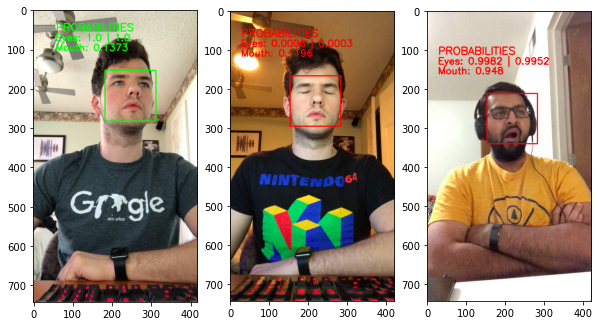

In [122]:
plt.figure(figsize=(10,10))
for i, img in enumerate(imgs):
    plt.subplot(1,len(imgs),i+1)
    plt.imshow(img)

plt.show()